In [2]:
import numpy as np
import matplotlib.pyplot as plt
import interneuron_amb
import stellate
from neuron import h

h.load_file("stdrun.hoc")
h.celsius = 37
h.cvode.active(1)
import importlib
importlib.reload(interneuron_amb)
importlib.reload(stellate)

<module 'stellate' from '/home/govind/gov_semproject/GridCellsTheta/GridCellsCond/stellate.py'>

In [3]:

stellate_0 = stellate.Stellate(0)
global_intrnrn = interneuron_amb.Interneuron(1)

gs_weight = 5.0
gs_inh_gmax = 2e-3  # uS
sg_weight = 1.0
sg_exc_gmax = 0.1e-2  # uS

nc_gs = h.NetCon(global_intrnrn.soma(0.5)._ref_v, stellate_0.inhb_syn, sec=global_intrnrn.soma)
nc_gs.weight[0] = gs_weight * gs_inh_gmax 

nc_sg = h.NetCon(stellate_0.soma(0.5)._ref_v, global_intrnrn.exc_syn, sec=stellate_0.soma)
nc_sg.weight[0] = sg_weight * sg_exc_gmax

theta_ic = h.IClamp(global_intrnrn.soma(0.5))
theta_ic.dur = 1e9
freq = 8
time_ms = 1000
osc_amp = 2.24e-3
T, num_steps = time_ms/1000,time_ms

"""
inhib_ic = h.IClamp(global_intrnrn.soma(0.5))
inhib_ic.dur = 1e9
inhib_ic.amp = 9e-4
"""
stell_ic = h.IClamp(stellate_0.soma(0.5))
stell_ic.dur = 1e9  
stell_ic.amp = 4e-3

time_arr = np.linspace(0,T,num_steps)
curr_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr)

curr_vec = h.Vector(curr_arr)
curr_vec.play(theta_ic._ref_amp, True)

spike_times = h.Vector()

nc = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc.threshold = 0
nc.record(spike_times)




0.0

17339


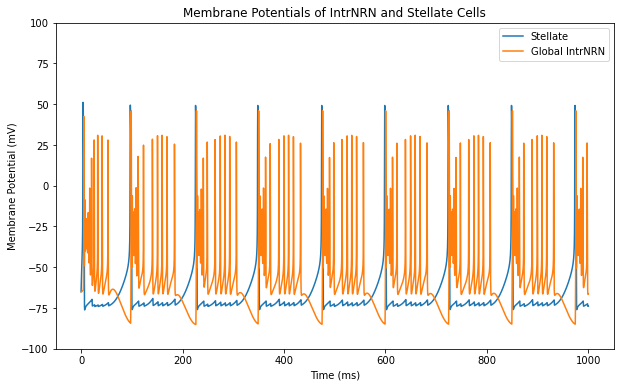

In [4]:
i_theta = h.Vector().record(theta_ic._ref_amp)

stellate_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
global_intrnrn_v = h.Vector().record(global_intrnrn.soma(0.5)._ref_v)
time = h.Vector().record(h._ref_t)


h.finitialize(-65)
h.continuerun(1000)
print(len(time.to_python()))
fig,ax = plt.subplots(figsize=(10,6))
#ax1 = ax.twinx()

ax.plot(time, stellate_v, label='Stellate')
ax.plot(time, global_intrnrn_v, label='Global IntrNRN')
##ax1.eventplot(spike_times, lineoffsets=-80, colors='r', linelengths=5, label='Stellate Spikes')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane Potential (mV)')
ax.set_title('Membrane Potentials of IntrNRN and Stellate Cells')
plt.legend()
plt.ylim(-100,100)
plt.show()



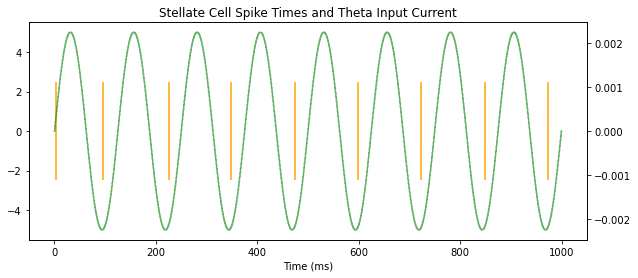

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax1 = ax.twinx()
ax.eventplot(spike_times, lineoffsets=0, colors='orange', linelengths=5)
ax1.plot(time, i_theta.to_python(), color='g', alpha=0.6)
ax.set_xlabel('Time (ms)')
ax.set_title('Stellate Cell Spike Times and Theta Input Current')
plt.show()
    

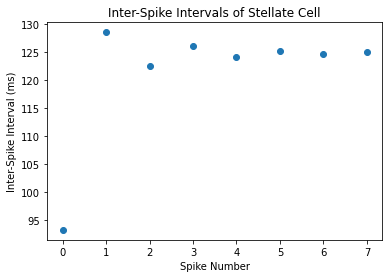

In [6]:
isi_array = np.diff(spike_times.to_python())    
plt.scatter(range(len(isi_array)), isi_array)
plt.xlabel('Spike Number') 
plt.ylabel('Inter-Spike Interval (ms)')
plt.title('Inter-Spike Intervals of Stellate Cell')
plt.show()                         

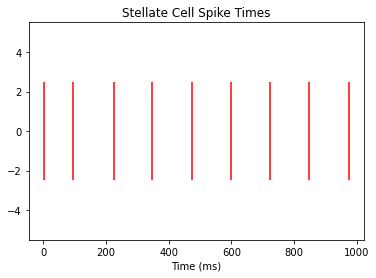

In [7]:
plt.eventplot(spike_times, lineoffsets=0, colors='r', linelengths=5)
plt.xlabel('Time (ms)')
plt.title('Stellate Cell Spike Times')
plt.show()